In [113]:
import torch
import sys
import os
import random
#sys.path.append('torchcore')
from PIL import Image
import numpy as np
import torch
from matplotlib import pyplot as plt
import json

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

from torchcore.dnn import networks
from torchcore.dnn.networks.center_net import CenterNet 
from torchvision.models import resnet50
from torchvision.transforms import ToPILImage
from torchcore.data.datasets import COCOPersonCenterDataset, COCOCenterDataset
from torchcore.data.transforms import Compose, RandomCrop, RandomScale, RandomMirror, ToTensor, Normalize
from torchcore.tools.visulize_tools import draw_single_box, visulize_heatmaps_with_image, draw_boxes,visulize_colored_heatmaps_with_image, draw_single_image
from torchcore.tools.color_gen import random_colors
from torchcore.dnn.networks.losses import FocalLossHeatmap, L1LossWithInd

from collections import OrderedDict


In [103]:
def get_dataset():
    anno_path = os.path.expanduser('~/data/annotations/coco2017_instances.pkl')
    root = os.path.expanduser('~/data/datasets/COCO')
    transform_list = []
    random_crop = RandomCrop((512,448)) #(width, height)
    #random_crop = RandomCrop(512)
    random_scale = RandomScale(0.6, 1.4)
    random_mirror = RandomMirror()
    to_tensor= ToTensor()
    normalize = Normalize()
    transform_list.append(random_scale)
    transform_list.append(random_crop)
    transform_list.append(random_mirror)
    #transform_list.append(to_tensor)
    #transform_list.append(normalize)
    transforms = Compose(transform_list)
    dataset = COCOCenterDataset(root=root, anno=anno_path, part='val2017',transforms=None)
    
    data_loader = torch.utils.data.DataLoader(
      dataset, 
      batch_size=1, 
      shuffle=True,
      num_workers=2,
      pin_memory=False,
      drop_last=True
    )
    return data_loader

In [105]:
dataset = get_dataset()

In [44]:
def dataset_test(dataset):
    index = random.randint(0, 99)
    #index = 1
    inputs, targets = dataset[index]
    #im = ToPILImage()(inputs['data'])
    ori_image = inputs['cropped_im']
    im = Image.fromarray(np.uint8(ori_image))
    #im = inputs['data']
    heatmap = targets['heatmap']
    #im.show()
    #heatmap_im = np.amax(heatmap,axis=0)
    #heatmap_im = Image.fromarray((heatmap_im*255).astype(np.uint8)).convert('RGB')
    #heatmap_im = heatmap_im.resize(im.size)
    #plt.figure()
    #plt.imshow(np.asarray(heatmap_im))
    #boxes = targets['boxes']
    #labels = targets['cat_labels']
    #for box in boxes:
    #    draw_single_box(im, box)
    #heatmap_im.show()
    
    #im_new = visulize_heatmaps_with_image(heatmap, im)
    im_new = visulize_colored_heatmaps_with_image(heatmap, im)
    #return im_new
    plt.figure()
    plt.imshow(np.asarray(im_new))
    #print(im.size)
    #data_loader = torch.utils.data.DataLoader(
    #  dataset, 
    #  batch_size=4, 
    #  shuffle=True,
    #  num_workers=2,
    #  pin_memory=True,
    #  drop_last=True
    #)
    #for inputs,targets in data_loader:
    #    print(inputs.keys())
    #    print(targets.keys())
    #    for k, v in inputs.items():
    #        print('{}:{}'.format(k, v.shape))
    #    for k, v in targets.items():
    #        print('{}:{}'.format(k, v.shape))
    #    break
    #im.show()

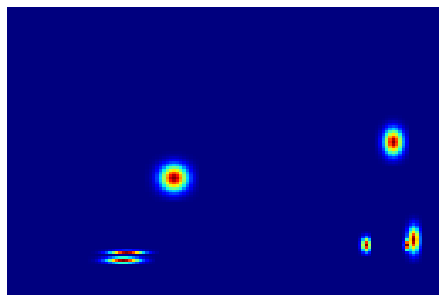

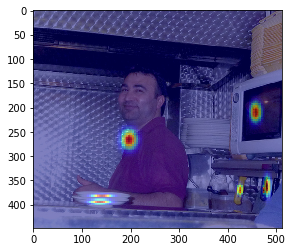

In [47]:
dataset_test(dataset)


In [48]:
def load_model():
    backbone = networks.feature.resnet50()
    in_channel = backbone.out_channel
    neck = networks.neck['upsample_basic'](in_channel)
    backbone.multi_feature = False
    #backbone.out_channel = 256
    #neck = None
    parts = ['heatmap', 'offset', 'width_height']
    #parts = ['heatmap']
    #model = CenterNet(backbone, 1, neck=neck, parts=parts)
    model = CenterNet(backbone, 80, neck=neck, parts=parts)
    path = '/home/dsv/qida0163/Vision/data/embedding/center_net_coco/checkpoints/checkpoints_20200507_centernet_coco_10_100.pkl'
    device = 'cpu'
    checkpoint = torch.load(path, map_location=device)
    state_dict = checkpoint['model_state_dict']
    state_dict_new = OrderedDict()
    for k, v in state_dict.items():
        if k[:6]=='module':
            state_dict_new[k[7:]] = state_dict[k]
        else:
            state_dict_new[k] = state_dict[k]

    model.load_state_dict(state_dict_new)
    return model

In [51]:
model = load_model()

<class 'torchcore.dnn.networks.necks.upsample.UpsampleNet'> is not initialized
<class 'torch.nn.modules.container.Sequential'> is not initialized
<class 'torchcore.dnn.networks.necks.upsample.BaseUpBlock'> is not initialized
<class 'torchcore.dnn.networks.necks.upsample.BaseUpBlock'> is not initialized
<class 'torchcore.dnn.networks.necks.upsample.BaseUpBlock'> is not initialized
<class 'torchcore.dnn.networks.heads.common_heads.CommonHead'> is not initialized
<class 'torch.nn.modules.container.Sequential'> is not initialized
<class 'torchcore.dnn.networks.heads.common_heads.CommonHead'> is not initialized
<class 'torch.nn.modules.container.Sequential'> is not initialized
<class 'torchcore.dnn.networks.heads.common_heads.CommonHead'> is not initialized
<class 'torch.nn.modules.container.Sequential'> is not initialized


In [95]:
def inference_test(dataset, model):
    model.eval()
    i=0
    thre = 0.2
    colors = random_colors(80)
    class_names = [
      'person', 'bicycle', 'car', 'motorcycle', 'airplane',
      'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
      'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
      'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
      'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
      'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
      'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
      'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
      'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
      'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
      'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
      'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
      'scissors', 'teddy bear', 'hair drier', 'toothbrush']
    for inputs, targets in dataset:
        result = model(inputs, targets)
        #print(result.keys())
        ori_image = inputs['cropped_im'][0].numpy()
        im = Image.fromarray(np.uint8(ori_image))
        boxes = result['boxes'][0].detach().numpy()
        scores = result['scores'][0].detach().numpy()
        category = result['category'][0].detach().numpy()
        
        #print(scores)
        #print(boxes[:3])
        inds = np.where(scores > thre)
        boxes = boxes[inds]
        scores = scores[inds]
        categories = category[inds]
        draw_single_image(im, boxes, scores, categories, colors, class_names)
        #for box, score, cat in zip(boxes, scores, category):
        #    if score>0.3:
        #        print(box, score, cat)
        #        draw_single_box(im, box)
        #        draw_single_image
        #im.show()
        plt.figure()
        plt.imshow(np.asarray(im))

        #print(ori_image.shape)
        #result['heatmap'] = torch.clamp(result['heatmap'].sigmoid_(), min=1e-4, max=1-1e-4)
        #heatmap = result['heatmap'][0][0].detach().numpy()
        #heatmap_im = Image.fromarray((heatmap*255).astype(np.uint8)).convert('RGB')
        #heatmap_im = heatmap_im.resize(im.size)
        ###heatmap = pred['heatmap'][0].detach().numpy()
        ###print(heatmap)
        ###visulize_heatmaps_with_image(heatmap, im)
        #heatmap_im.show()
        #im.show()
        #print(ori_image[0].size())
        #for k, v in pred.items():
        #    print('{}:{}'.format(k, v.shape))
        #break
        i+=1
        if i==5:
            break

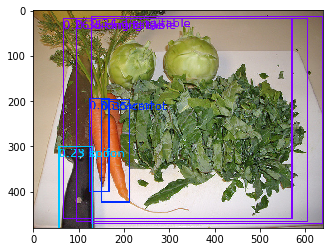

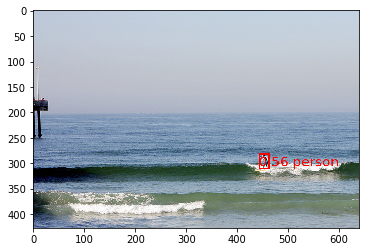

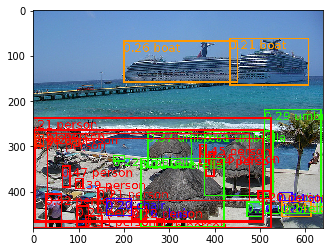

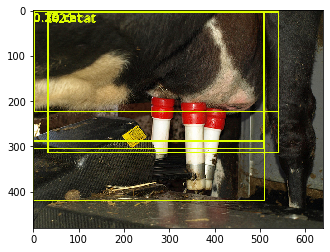

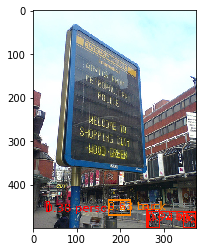

In [108]:
inference_test(dataset, model)

In [111]:
def eval_result(dataset='coco_person'):
    if dataset not in ['coco','coco_person', 'modanet']:
        raise ValueError('only support coco_person and modanet dataset')
    if dataset == 'coco_person':
        gt_json=os.path.expanduser('~/data/datasets/COCO/annotations/instances_val2014.json')
    if dataset == 'coco':
        gt_json=os.path.expanduser('~/data/datasets/COCO/annotations/instances_val2017.json')
    else:
        gt_json=os.path.expanduser('~/data/datasets/modanet/Annots/modanet_instances_val.json')
    dt_json='temp_result.json'

    # we need to map the category ids back
    if dataset == 'coco':
        cat_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
        with open(dt_json) as f:
            results = json.load(f)
            for result in results:
                temp_id = result['category_id']
                result['category_id'] = cat_ids[temp_id-1]
            with open('temp_result.json','w') as f:
                json.dump(results,f)

    annType = 'bbox'
    cocoGt=COCO(gt_json)
    cocoDt=cocoGt.loadRes(dt_json)

    imgIds=sorted(cocoGt.getImgIds())

    # running evaluation
    cocoEval = COCOeval(cocoGt,cocoDt,annType)
    if dataset == 'coco_person':
        cocoEval.params.catIds = [1]
    cocoEval.params.imgIds = imgIds
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

In [114]:
eval_result(dataset='coco')

loading annotations into memory...
Done (t=0.78s)
creating index...
index created!
Loading and preparing results...
DONE (t=4.28s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=71.61s).
Accumulating evaluation results...
DONE (t=13.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.219
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.259
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.303
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.229
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDe